## Initialzing and loading required libraries and subfunctions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle


import sys
import os

src_dir = os.path.abspath(os.path.join('..', 'src'))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [41]:
path_to_hpc = '/Users/amir/Desktop/for Abdel/Theta-Gamma-Copuling/data/example data/HPC_100_CH32_0.continuous.mat'
path_to_states = '/Users/amir/Desktop/for Abdel/Theta-Gamma-Copuling/data/example data/2018-11-05_14-15-28_post_trial5-states.mat'

In [42]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/Theta-Gamma-Copuling/data/emd_masksift_CA1_config_2500.yml')

In [43]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [44]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

There was 0 in the dataset


In [45]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)


Number of detected Tonic intrevals:54
Number of detected Tonic intrevals after threshold:54


In [46]:
# version 1

def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    # Check if any cycles satisfy the conditions
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs

In [54]:
# First extract waveforms from both phasic and tonic signals
phasic_waveforms, phasic_trials, phasic_FPPs = prepare_data_for_umap(phasic_imfs, phasic_imfs_freqs)
tonic_waveforms, tonic_trials, tonic_FPPs = prepare_data_for_umap(tonic_imfs, tonic_imfs_freqs)

# Combine the waveforms for fitting the UMAP model
combined_waveforms = pd.concat([phasic_waveforms, tonic_waveforms])


 Checking Cycles inputs - trimming singleton from input 'IP'
2731
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
3280
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
8160
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2975
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2275
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2495
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
6825
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2605
 Checking 

In [ ]:
# Create a UMAP model with 3 components
ID = 3
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=ID, 
                         metric='euclidean', random_state=42)

# Fit the model on combined data and transform
combined_embedding = umap_embedder.fit_transform(combined_waveforms.to_numpy())

# Split the embedding back to phasic and tonic
phasic_embedding = combined_embedding[:len(phasic_waveforms)]
tonic_embedding = combined_embedding[len(phasic_waveforms):]

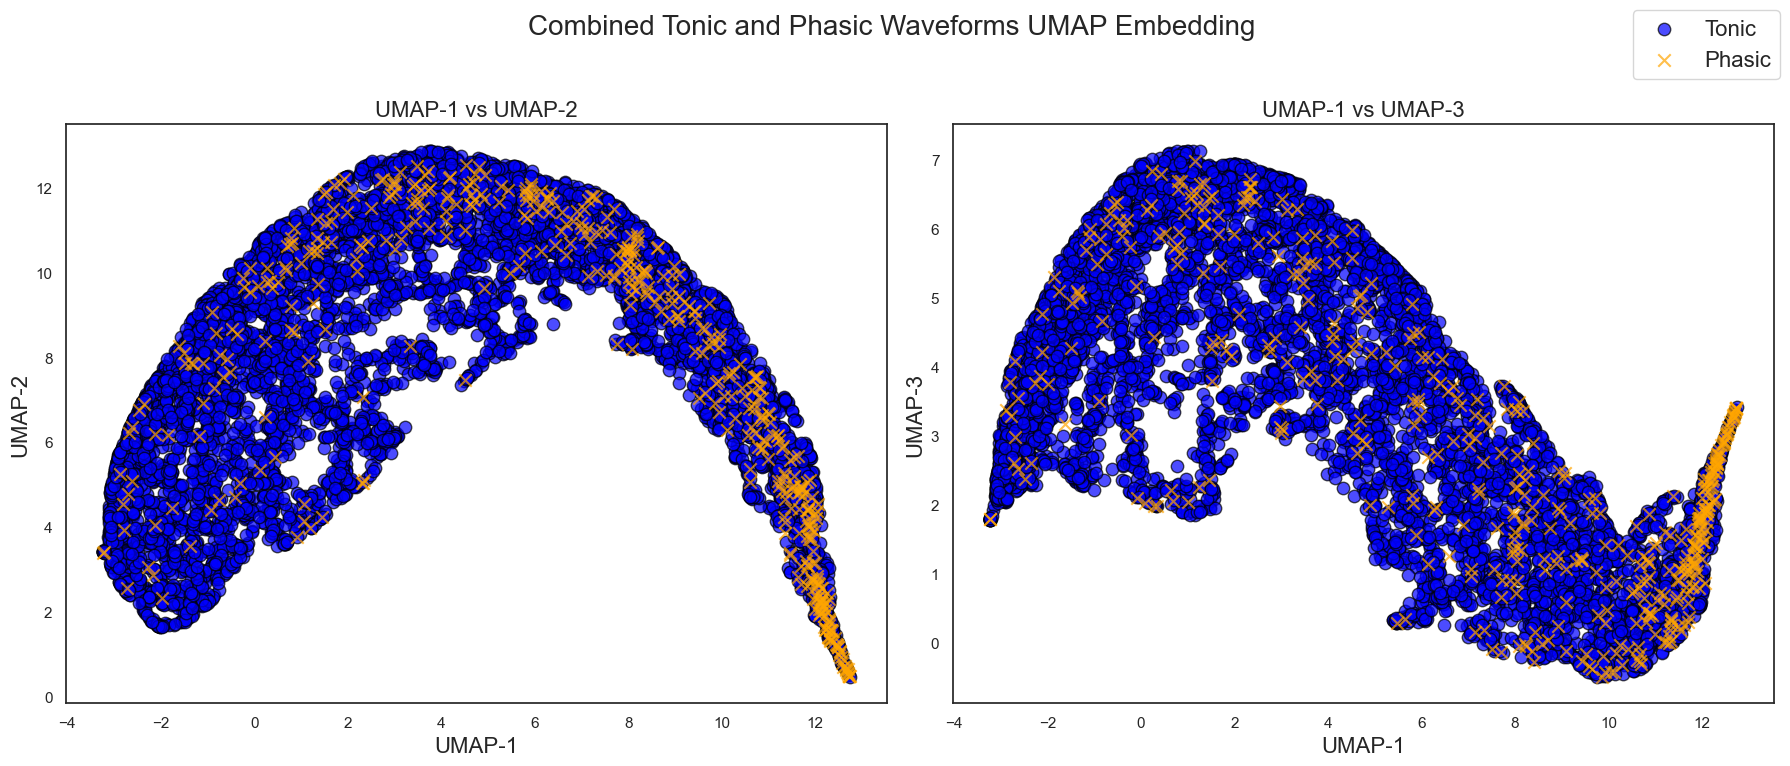

In [56]:
# Visualize the results
rem_color = 'purple'
tonic_color = 'blue'
phasic_color = 'orange'

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot UMAP-1 vs UMAP-2
# Tonic episodes
scatter_tonic = ax[0].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                             c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

# Phasic episodes
scatter_phasic = ax[0].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                              c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[0].set_xlabel('UMAP-1', fontsize=16)
ax[0].set_ylabel('UMAP-2', fontsize=16)
ax[0].set_title('UMAP-1 vs UMAP-2', fontsize=16)

# Plot UMAP-1 vs UMAP-3
scatter_tonic = ax[1].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                             c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

scatter_phasic = ax[1].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                              c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[1].set_xlabel('UMAP-1', fontsize=16)
ax[1].set_ylabel('UMAP-3', fontsize=16)
ax[1].set_title('UMAP-1 vs UMAP-3', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("Combined Tonic and Phasic Waveforms UMAP Embedding", fontsize=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

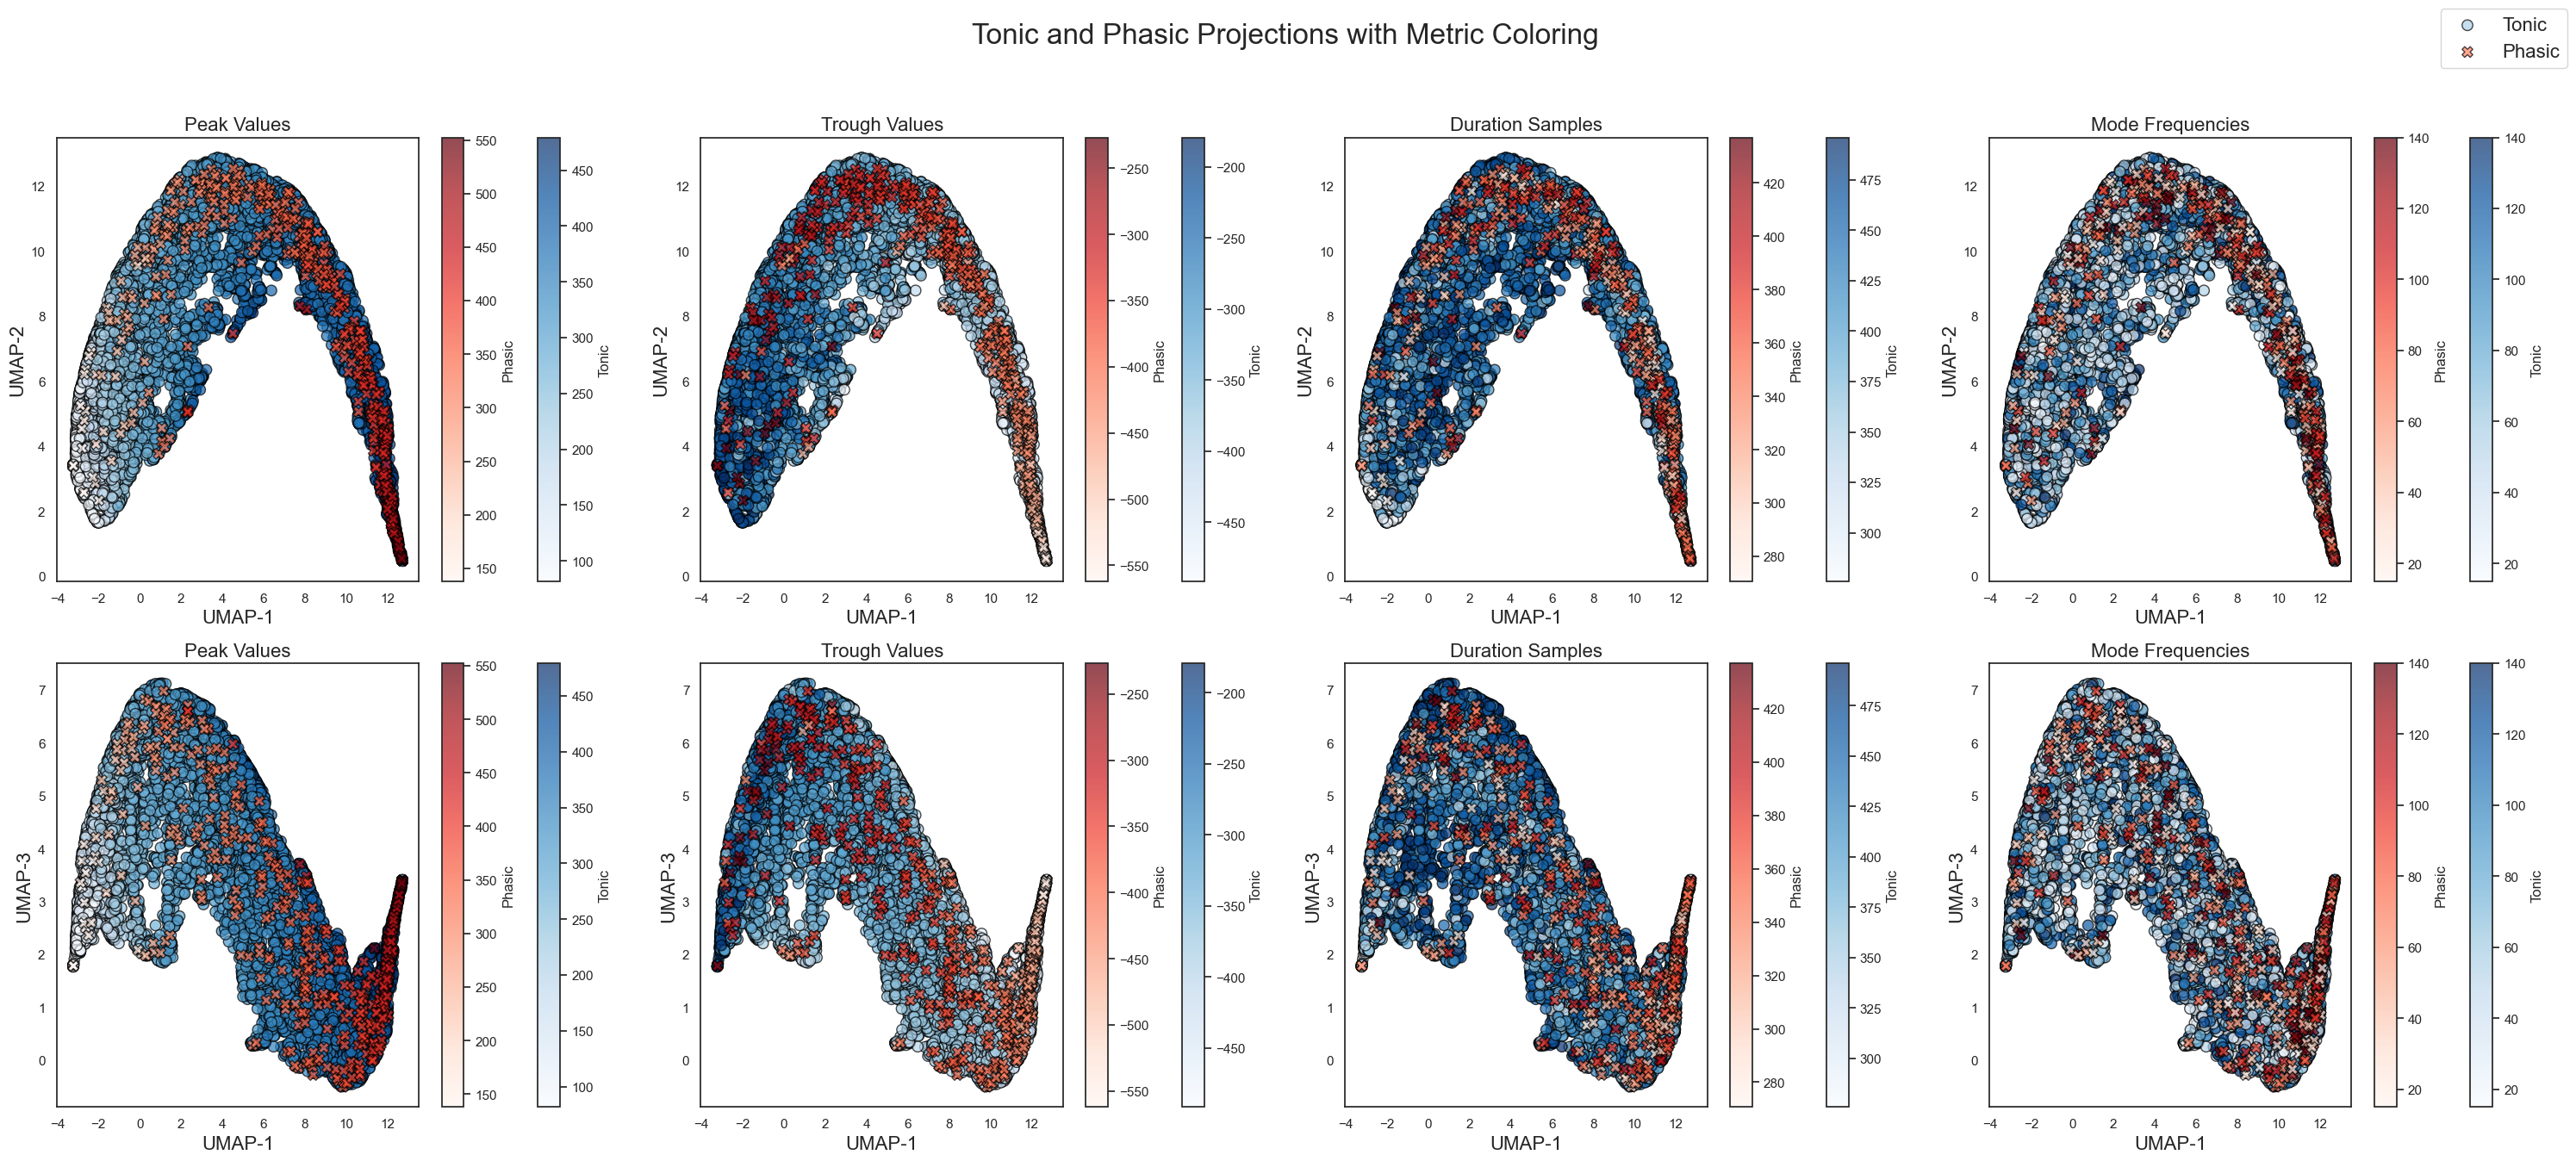

In [55]:
# Define metrics to visualize
metrics = ['peak_values', 'trough_values', 'duration_samples', 'mode_freqs']
titles = ['Peak Values', 'Trough Values', 'Duration Samples', 'Mode Frequencies']

# Define color maps
tonic_cmap = 'Blues'
phasic_cmap = 'Reds'

# Create subplot grid
f, ax = plt.subplots(2, 4, figsize=(30, 14))

for i, metric in enumerate(metrics):
    # UMAP-1 vs UMAP-2 with metric coloring
    scatter_tonic = ax[0, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    scatter_phasic = ax[0, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

    # UMAP-1 vs UMAP-3 with metric coloring
    scatter_tonic = ax[1, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    scatter_phasic = ax[1, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

# Add legend
handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

# Add title and adjust layout
plt.suptitle("Tonic and Phasic Projections with Metric Coloring", fontsize=24)
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [57]:
from structure_index import compute_structure_index, draw_graph

In [58]:
# Rotation and Translation of dataset to align it to another dataset (template) based on a feature
# Arguments:
# data = Dataset of size N to be aligned
# feature = an array of size N representing alignment feature
# template_data = Dataset to which (data) will be aligned
# template_feature = an array representing alignment feature of the template data
def align_point_cloud(data, feature,
                      template_data,
                      template_feature,
                      n_bins=15,
                      n_neighbors=15,
                      dims=None,
                      distance_metric='euclidean',
                      discrete_label=False,
                      num_shuffles=10,
                      verbose=False):
    params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

    # Get bins from the data
    SI, binLabel, overlapMat, sSI = compute_structure_index(data, np.array(feature), **params)
    SI_temp, binLabel_temp, overlapMat_temp, sSI_temp = compute_structure_index(template_data, np.array(template_feature), **params)

    # Get centroids of bins (p and p'); these are the points that will be aligned
    p = []
    for i in range(params['n_bins']):
        p.append(np.mean(data[binLabel[0] == i], axis=0))
    p = np.array(p)
    
    p_temp = []
    for i in range(params['n_bins']):
        p_temp.append(np.mean(template_data[binLabel_temp[0] == i], axis=0))
    p_temp = np.array(p_temp)

    # q = p - mean(p)
    # Get deviations of points from their means (q and q'); the Qs are used to get the scatter matrix H
    p_mean = np.mean(p, axis=0)
    p_temp_mean = np.mean(p_temp, axis=0)
    q = p - p_mean
    q_temp = p_temp - p_temp_mean

    # Get Rotation matrix
    H = np.dot(q_temp.T, q)
    U, S, Vh = np.linalg.svd(H, full_matrices=True)
    R = np.dot(U, Vh)
    if np.linalg.det(R) < 0:
        Vh[Vh.shape[0]-1, :] = Vh[Vh.shape[0]-1, :] * (-1)
        R = np.dot(U, Vh)

    T = p_temp_mean - np.dot(p_mean, R)
    new_data = np.dot(data, R) + T
    return new_data

In [59]:
n_bins=5
n_neighbors=15
dims=None
distance_metric='euclidean'
discrete_label=False
num_shuffles=10
verbose=True

params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

In [60]:
combined_trials = pd.concat([phasic_trials, tonic_trials])

In [61]:
peaks = np.array(combined_trials['peak_values'])

In [63]:
combined_waveforms = np.array(combined_waveforms)

In [64]:
SI, binLabel, overlapMat, sSI = compute_structure_index(combined_waveforms, np.array(peaks), **params)

Computing bin-groups..: Done


Computing overlap:   0%|          | 0/10 [00:00<?, ?it/s]

Computing structure index..: 0.96


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.00


In [65]:
print(f"Structure Index (SI): {SI}")

Structure Index (SI): 0.9615074340393159


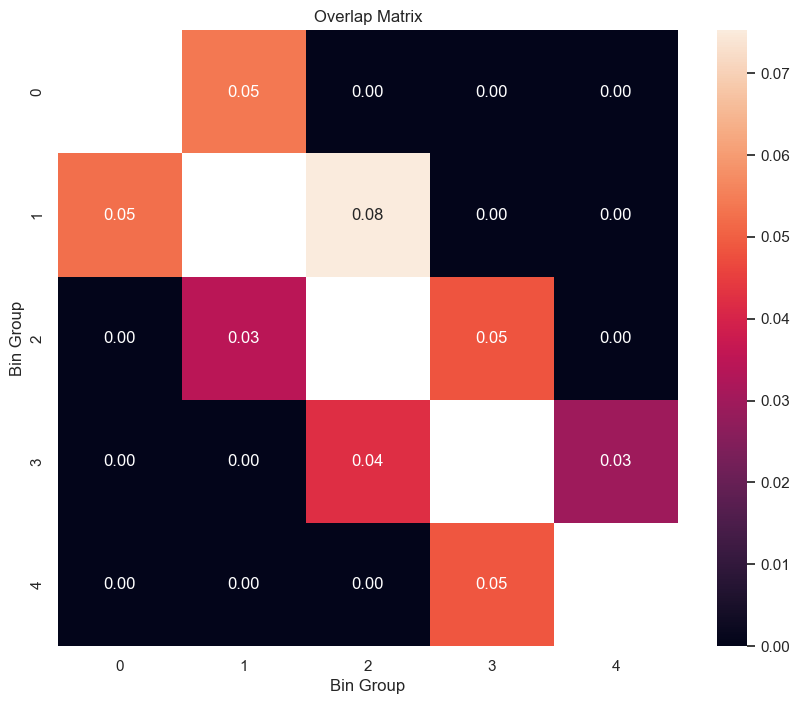

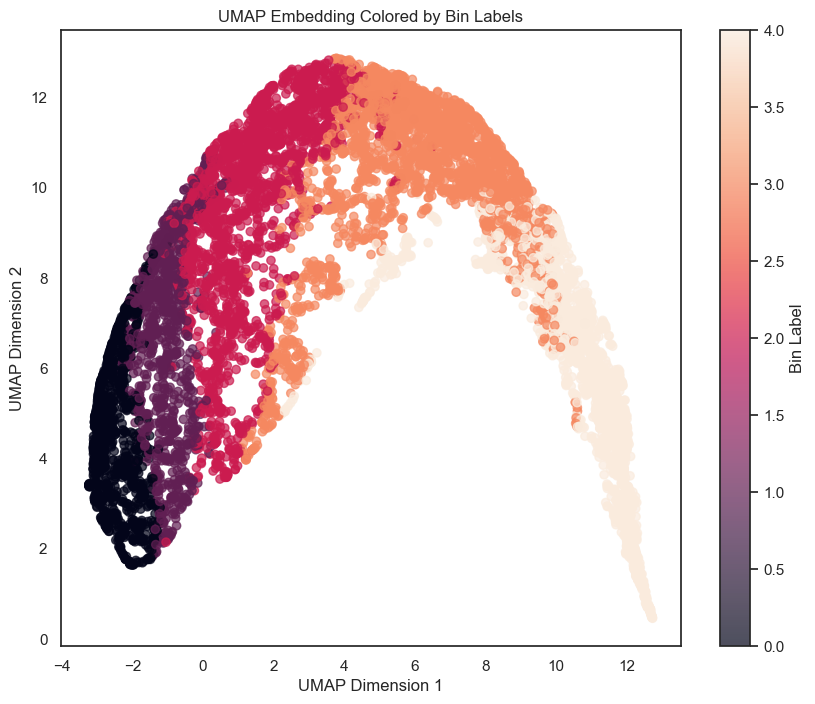

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the overlap matrix
plt.figure(figsize=(10, 8))
sns.heatmap(overlapMat, annot=True, fmt=".2f")
plt.title('Overlap Matrix')
plt.xlabel('Bin Group')
plt.ylabel('Bin Group')
plt.show()

# Plot the UMAP embedding colored by bin labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(combined_embedding[:, 0], combined_embedding[:, 1], c=binLabel[0], alpha=0.7)
plt.title('UMAP Embedding Colored by Bin Labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Bin Label')
plt.show()